# Multi-class classification

Previously, we looked at how the [logistic regression model](classification-logistic-regression-model) can be used to tackle two-class classification problems. In many problems of interest there are multiple classes. In this section we extend the logistic regression classifier to handle multiple classes.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from IPython.display import HTML, set_matplotlib_formats

set_matplotlib_formats('pdf', 'svg')
css_style = open('../../_static/custom_style.css', 'r').read()
HTML(f'<style>{css_style}</style>')

%config InlineBackend.figure_format = 'svg'

##  The Softmax classification model

As before, each datapoint comprises an input $\mathbf{x}_n$ and an output value $y_n$. Now the output $y_n = k$ indicates which of $K$ classes the $n^{th}$ datapoint belongs to. Binary classification is recovered when $K = 2$, wheras $K > 2$ corresponds to multi-class classification.

The equivalent of the logistic regression model for multiple classes is the softmax classification model. Like logistic regression, softmax is also comprised of two stages. The first stage computes $k$ activations $a_{n,k} = \mathbf{w}_k^\top \mathbf{x}_n$ using a weight vector for each class $\{\mathbf{w}_k\}_{k=1}^K$. The second stage passes this set of activations into a **softmax function** which returns the probability that the datapoint belongs to each of the K classes (i.e. a K dimensional vector of probabilities) which has elements 

$$\begin{align}
p(y_{n} = k |\mathbf{x}_n, \{\mathbf{w}_k\}_{k=1}^K) = \frac{\exp(a_{n,k})}{\sum_{k'=1}^K \text{exp}(a_{n,k'})} = \frac{\text{exp}(\mathbf{w}_k^\top \mathbf{x}_n)}{\sum_{k'=1}^K \exp(\mathbf{w}_{k'}^\top \mathbf{x}_n)}.
\end{align}$$

Notice that by construction the softmax function is normalised 

$$\begin{align}
\sum_{k=1}^K p(y_{n} = k |\mathbf{x}_n, \{\mathbf{w}_k\}_{k=1}^K) = \frac{\sum_{k=1}^K \exp(a_{n,k})}{\sum_{k'=1}^K \text{exp}(a_{n,k'})} = 1.
\end{align}$$

In this way, the softmax parameterises a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) over the output variable, whereas the logistic function parameterised a [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution).

### Visualising softmax models

Let's plot some examples of this model for $K = 3$ classes and $D = 2$ dimensional inputs. First we implement the `softmax` function for convenience. We then draw four different random realisations of a softmax classification model. Each random realisation has its own weights $W^{(m)} = [\mathbf{w}_1^{(m)},\mathbf{w}_2^{(m)},\mathbf{w}^{(m)}_3]$. Each row in the plots below shows the softmax probabilities for the three classes of a random softmax model, as a function of the input variables. The three columns correspond to the three classes.

In [2]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1)[:, None]

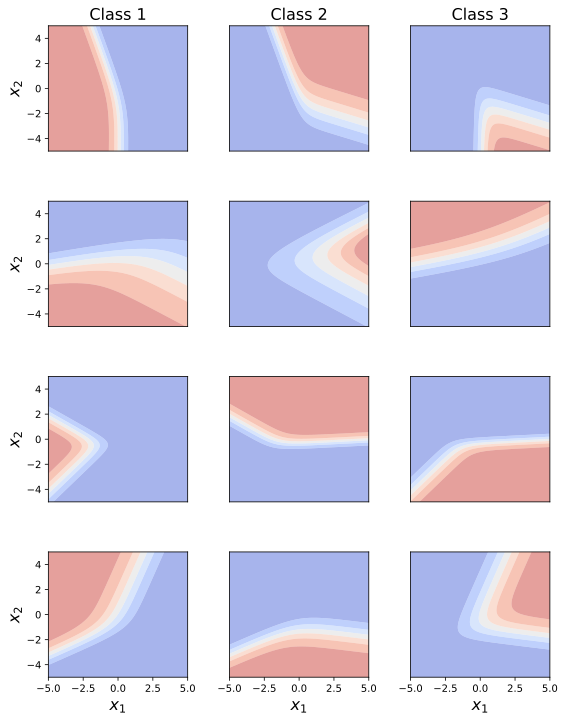

In [3]:
# Set random seed
np.random.seed(0)

# Number of points in each dimension for grid discretisation
num_grid_pts = 100

# Number of softmax samples to draw
num_samples = 4

# Input coordinates of grid points
x1 = np.linspace(-5, 5, num_grid_pts)
x2 = np.linspace(-5, 5, num_grid_pts)

# Figure to plot on
fig = plt.figure(figsize=(9, 12))

# Loop over number of samples
for i in range(num_samples):
    
    # Draw matrix of weights
    W = np.random.randn(3, 3)
    
    # Create grid of points
    grid = np.stack(np.meshgrid(x1, x2), axis=-1)
    grid = grid.reshape((-1, 2))
    grid = np.append(np.ones(shape=(grid.shape[0], 1)), grid, axis=1)
    
    # Compute softmax probabilities
    probs = softmax(grid @ W)
    probs = probs.reshape((num_grid_pts, num_grid_pts, 3))
    
    # For each of the three classes, plot the class probability over the grid
    for c in range(3):
        
        # adding a subplot in appropriate location
        ax = fig.add_subplot(4, 3, 3 * i + c + 1)
        
        ax.contourf(x1,x2,probs[:,:,c-1],cmap=plt.cm.coolwarm,alpha=0.5)
        
        if c == 0:
            plt.ylabel('$x_2$', fontsize=16)
        else:
            plt.yticks([])
            
        if i == 3:
            plt.xlabel('$x_1$', fontsize=16)
        else:
            plt.xticks([])
            
        if i == 0:
            plt.title(f'Class {c+1}', fontsize=16)

plt.subplots_adjust(hspace = 0.4,wspace = 0.3)
plt.show()

Note that the probability contours for a given class are not linear. However it turns out that the decision boundaries, that is the boundaries where the most probable class changes from one to another, are in fact linear. For more insight into the softmax function, see [question 1](#Questions) below.

## Fitting using maximum likelihood

Having gained some intuition about the model, we now consider maximum likelihood fitting. The likelihood can be written in a compact form using a one-hot encoding of the class labels. That is, we can encode the output $y_n=k$ into a vector of length $K$ comprising $K-1$ zeros and a one in the $k^{\text{th}}$ element e.g. for $K=4$ classes if the $n^{\text{th}}$ datapoint belongs to the third class $y_n=3$ we have $\mathbf{y}_n = [0,0,1,0]$. These one-hot encodings can be stacked into an N-by-K matrix with elements $y_{n,k}$ and will help us do the book keeping associated with computing the correct output probability for each datapoint. Armed with this new representation of the output, we can write the probability of the output given the weights and the inputs as,

$$\begin{align}
p(\{y_{n}\}_{n=1}^N|\{\mathbf{x}_n\}_{n=1}^N, \{\mathbf{w}_k\}_{k=1}^K) &= \prod_{n = 1}^N \prod_{k = 1}^K s_{n,k}^{y_{n,k}}.
\end{align}$$

Here we have denoted the output of the softmax function for each datapoint as

$$\begin{align}
s_{n,k} = p(y_{n} = k |\mathbf{x}_n, \{\mathbf{w}_k\}_{k=1}^K) = \text{exp}(\mathbf{w}_k^\top \mathbf{x}_n)\big/\sum_{k'} \exp(\mathbf{w}_{k'}^\top \mathbf{x}_n).
\end{align}$$

In case it is not clear, let's briefly consider the the trick of raising the softmax output to the power $y_{n,k}$ through a simple example. Let $N=1$ and $y_1 = 3$ so that $\mathbf{y}_1 = [y_{1,1},y_{1,2},y_{1,3},y_{1,4}] = [0,0,1,0]$. The right hand side of the likelihood is therefore

$$\begin{align}
\prod_{k = 1}^K s_{n,k}^{y_{n,k}} = s_{n,1}^{0} s_{n,2}^{0} s_{n,3}^{1} s_{n,4}^{0} = s_{n,3}^{1} = p(y_{1} = 3 |\mathbf{x}_n, \{\mathbf{w}_k\}_{k=1}^K).
\end{align}$$

So everything works as it should do. The probability of the output given the weights and the inputs is also called the likelihood of the parameters. The log-likelihood is therefore

$$\begin{align}
\mathcal{L}(\{\mathbf{w}\}_{k=1}^K) &= \sum_{n = 1}^N \sum_{k = 1}^K y_{n,k} \log s_{n,k}
\end{align}$$

Now we can numerically optimise the log-likelihood using gradient ascent. This requires computation of the derivatives of $\mathcal{L}(\{\mathbf{w}\}_{k=1}^K)$ with respect to the weights, 

$$\begin{align}
\frac{\partial \mathcal{L}(\{\mathbf{w}\}_{k=1}^K)}{\partial \mathbf{w}_j} = \sum^N_{n = 1} (y_{n,j} - s_{n,j}) \mathbf{x}_n.
\end{align}$$

The full derivation of the gradient can be found below. Notice how it is composed of a sum over contributions from each datapoint, and each contribution involves the prediction error $y_{n,j} - s_{n,j}$ multiplied by the input $\mathbf{x}_n$. 

<details class='graydrop'>
<summary>Derivation of the gradient of the softmax log-likelihood</summary>
    
Starting from the expression

$$\begin{align}
\mathcal{L}(\{\mathbf{w}\}_{k=1}^K) &= \sum_{n = 1}^N \sum_{k = 1}^K y_{n,k} \text{log}~s_{n,k},
\end{align}$$

and taking the derivative w.r.t. $\mathbf{w}_j$ we see:


$$\begin{align}
\frac{\partial \mathcal{L}(\{\mathbf{w}\}_{k=1}^K)}{\partial \mathbf{w}_j} &= \sum_{n = 1}^N\sum_{k = 1}^K y_{n,k} \frac{1}{s_{n,k}} \frac{\partial s_{n,k}}{\partial \mathbf{w}_j} = \sum_{n = 1}^N\sum_{k = 1}^K y_{n,k} \frac{1}{s_{n,k}} \frac{\partial s_{n,k}}{\partial a_{n,j}} \frac{\partial a_{n,j}}{\mathbf{w}_j}\\
&= \sum_{n = 1}^N\sum_{k = 1}^K y_{n,k} (\delta_{k,j} - s_{n,j}) \mathbf{x}_n
\end{align}$$

where $\delta_{k,j}$ is a [Kronecker delta](https://en.wikipedia.org/wiki/Kronecker_delta) and we have used the identity

$$\begin{align}
\frac{\partial s_{n,k}}{ \partial a_{n,j}} = s_{n,k}(\delta_{k,j} - s_{n,j}).
\end{align}$$

Then considering that for each $n$, $y_{n,k}$ is $1$ for a single value of $k$ and $0$ for all other values of $k$:

$$\begin{align}
\frac{\partial \mathcal{L}(\{\mathbf{w}\}_{k=1}^K)}{\partial \mathbf{w}_j} &= \sum_{n = 1}^N\sum_{k = 1}^K y_{n,k}(\delta_{k,j} - s_{nj})\mathbf{x}_n\\
&= \sum_{n = 1}^N\sum_{k = 1}^K (y_{n,j} - s_{n,j})\mathbf{x}_n
\end{align}$$

arriving at the final result.
</details>
<br>

Now let's write down code for gradient ascent of the softmax classification likelihood, just as we did for logistic classication.

In [4]:
def softmax_gradient_ascent(x, y, w0, num_steps, stepsize):
    
    # Add 1's to the inputs as usual, absorbing the bias term
    x = np.append(np.ones(shape=(x.shape[0], 1)), x, axis=1)
    
    # Copy weights (to prevent changing w0 as a side-effect)
    w = w0.copy() 
    
    # Arrays for storing weights and log-liklihoods at each step
    w_history = []
    log_liks = []

    for n in range(num_steps):
        
        # Record current log-lik and current weights
        class_probs = softmax(x @ w)
        log_lik = np.sum(y * np.log(class_probs))
        
        log_liks.append(log_lik)
        w_history.append(w.copy())

        dL_dw = (x.T).dot(y - class_probs) / x.shape[0]
        w += stepsize * dL_dw
    
    return np.array(w_history), np.array(log_liks)

We can now run gradient ascent on the Iris dataset with all 3 classes included. Let's start by running it with just two of the input dimensions retained (sepal length and width) so that we can visualise the results easily. In the plot below, each point is coloured with the RGB value representing the probabilistic prediction the trained model makes for each class ($0$,$1$ and $2$ respectively) at this location. 

In [7]:
# Load input and output data of the multi-class iris dataset
x_data = np.load('data/iris_inputs_full.npy')
y_data = np.load('data/iris_labels.npy')

num_classes = np.max(y_data)
num_data = y_data.shape[0]

# Convert output data to one-hot
y_data = np.eye(num_classes + 1)[y_data]

# Number of points to use for training
num_train = (num_data * 3) // 4

x_train = x_data[:num_train, :2]
x_valid = x_data[num_train:, :2]
y_train = y_data[:num_train]
y_valid = y_data[num_train:]

In [8]:
# Initial weights
w0 = np.zeros(shape = (x_train.shape[1] + 1, 3))

# Number of training steps and stepsize
num_steps = int(1e4)
stepsize = 5e-2

# Perform gradient ascent training
w_history, log_liks = softmax_gradient_ascent(x_train,
                                              y_train,
                                              w0,
                                              num_steps,
                                              stepsize)

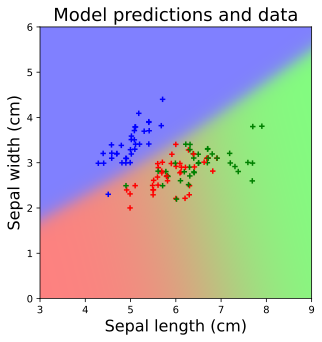

In [9]:
# Grid locations to plot predictive probilities
grid = np.meshgrid(np.linspace(3, 9, 200), np.linspace(0, 6, 200))
grid = np.stack(grid, axis=-1).reshape((-1, 2))
grid = np.append(np.ones(shape = (grid.shape[0], 1)), grid, axis = 1)

# Compute predictive probabilities at input locations
probs = softmax(grid.dot(w_history[-1])).reshape((200, 200, 3))
rgb_colors = np.roll(probs, -1, axis  = -1)
idx = np.argmax(y_train, axis=1)
datapoint_colors = np.array(['b', 'r', 'g'])[idx]

# Figure to plot on
plt.figure(figsize=(6, 5))

# Plot model predictions and datapoints
plt.imshow(rgb_colors,
           extent=[3, 9, 0, 6],
           alpha=0.5,
           origin='lower')

plt.scatter(x_train[:, 0],
            x_train[:, 1],
            marker = '+',
            s=30,
            color=datapoint_colors)

# Format plot
plt.title('Model predictions and data', fontsize=18)
plt.xlabel(f'Sepal length (cm)', fontsize=16)
plt.ylabel(f'Sepal width (cm)', fontsize=16)
plt.show()

Now that we have visualised the probabilities, we can apply the gradient-ascent algorithm to the full Iris dataset, with all of the input dimesions retained. First lets see how the log-likelihood changes with iteration number:

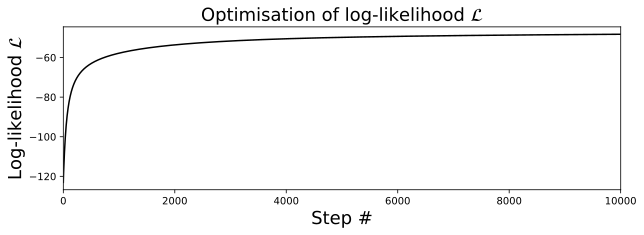

In [10]:
# Number of training steps and stepsize
num_steps = int(1e4)
stepsize = 1e-1

# Initial weights
w0 = np.zeros(shape=(x_train.shape[1] + 1, 3))

w_history, log_liks = softmax_gradient_ascent(x_train,
                                              y_train,
                                              w0,
                                              num_steps,
                                              stepsize)

# Figure to plot on
plt.figure(figsize=(10, 3))

# Plot log-likelihood
plt.plot(log_liks, color='black')

plt.title('Optimisation of log-likelihood $\mathcal{L}$', fontsize=18)
plt.xlabel('Step #', fontsize=18)
plt.ylabel('Log-likelihood $\mathcal{L}$', fontsize=18)
plt.xlim([0, num_steps+1])
plt.show()

Now lets test the accuracy of our model on the test data. We write this as a convenient helper function `softmax_test_accuracy`.

In [11]:
def softmax_accuracy(x, y, w):
    
    # Append 1's to input data as before 
    x = np.append(np.ones(shape=(x.shape[0], 1)), x, axis=1)
    
    # Compute predictive probabilities for each class
    pred_probs = softmax(x @ w)
    
    # Compute fraction of correct predictions
    corrects = np.argmax(pred_probs, axis=1) == np.argmax(y, axis=1)
    accuracy = np.mean(corrects)
    
    return accuracy

accuracy = softmax_accuracy(x_valid, y_valid, w_history[-1])

print(f'Classification accuracy for full iris dataset = '
      f'{100*accuracy:.2f}%')

Classification accuracy for full iris dataset = 84.21%


### Summary

The multi-class softmax classification model comprises two steps:  

1. Compute $K$ activations, one for each class, each of which are linear projections of the input $a_{n,k} = \mathbf{w}_k^\top \mathbf{x}_n$.
2. Pass the $K$ activations into the softmax function to get a vector of $K$ elements which are the class membership probabilities

$$\begin{align}
p(y_{n} = k |\mathbf{x}_n, \{\mathbf{w}_k\}_{k=1}^K) = \frac{\text{exp}(\mathbf{w}_k^\top \mathbf{x}_n)}{\sum_{k'} \exp(\mathbf{w}_{k'}^\top \mathbf{x}_n)}.
\end{align}$$

The log-likelihood and its derivatives can be compactly written using a one-hot encoding of the training data's outputs. Gradient ascent can then be used to numerically optimise the log-likelihood. In the [next section](classification-non-linear.ipynb) we will look at how to generalise this method to non-linear classification.

## Questions

<ol start="1">
<li> <b>Why the name 'softmax' and relating softmax classification to logistic classification</b> Consider the softmax classification function:

$$\begin{align}
p(y_{k} = k |\mathbf{x}, \{\mathbf{w}_k\}_{k=1}^K)  = \frac{\text{exp}(\mathbf{w}_k^\top \mathbf{x})}{\sum_{k'=1}^K \exp(\mathbf{w}_{k'}^\top \mathbf{x})},
\end{align}$$

What happens to the softmax function as the magnitude of the weights tends to infinity $|\mathbf{w}_k| \rightarrow \infty$?

Consider K=2 classes, compare and contrast the softmax classification model to binary logistic classification. Is the softmax function **[identifiable](https://en.wikipedia.org/wiki/Identifiability)**?

<br>

<details class='graydrop'>
<summary>Answer</summary>
    
$$\begin{align}
y_k(x, W) = \frac{e^{w_k^\top x}}{\sum_{k = 1}^K e^{w_k^\top x}}
\end{align}$$

**First part:** We write the weight vectors as

$$\begin{align}
w_k = \beta \hat{w}_k,
\end{align}$$

where $\beta$ is a magnitude scalar and $\hat{w}_k$ is the unit vector parallel to $w_k$. We can therefore write

$$\begin{align}
y_k(x, W) &= \frac{e^{\beta\hat{w}_k^\top x}}{\sum_{k = 1}^K e^{\beta\hat{w}_k^\top x}}, \\
          &= \frac{e^{\beta(\hat{w}_k - \hat{w}_{max})^\top x}}{\sum_{k = 1}^K e^{\beta(\hat{w}_k - \hat{w}_{max})^\top x}}.
\end{align}$$
    
where we have defined $\hat{w}_{max}$ as
    
$$\begin{align}
\DeclareMathOperator*{\argmax}{arg\,max}
\hat{w}_{max} = \argmax_{\hat{w}_k \in \hat{w}_1, ..., \hat{w}_K} \hat{w}_k^\top x.
\end{align}$$
    
Note that $(\hat{w}_k - \hat{w}_{max})^\top x$ are all scalars, of which at least one is zero and the others are all negative. Let the zero-terms have indices $i_1, ..., i_M$, that is
    
$$\begin{align}
\DeclareMathOperator*{\argmax}{arg\,max}
\hat{w}_{i_m}^\top x = 0, \text{ for all } m = 1, ..., M.
\end{align}$$   

Now, as $\beta \to \infty$ we have
    
$$\begin{align}
e^{(\hat{w}_k - \hat{w}_{max})^\top x} \to \begin{cases}
1 & \text{ if } k \not \in \{i_1, ..., i_M\}, \\
0 & \text{ otherwise.}
\end{cases}
\end{align}$$
    
Therefore, the quantity $y_k(x, W)$ tends to the corresponding limit which is
    
$$\begin{align}
y_k(x, W) \to \begin{cases}
\frac{1}{M} & \text{ if } k \in \{i_1, ..., i_M\}, \\
0 & \text{ otherwise.}
\end{cases}
\end{align}$$
    
In the case where $M = 1$, we have
    
$$\begin{align}
y_k(x, W) = \mathbb{1}\left(\argmax_{k'} \hat{w}_{k'}^\top x = k \right),
\end{align}$$
    
which is a one-zero encoding of the argmax function. The soft-max is a 'softer' version of the argmax function (and becomes the argmax function in the limit $\beta \to \infty$), from which it gets its name.
    
**Second part:** Consider the case of $K = 2$ classes. Then we can write
    
$$\begin{align}
y_1(x, W) &= \frac{e^{w_1^\top x}}{e^{w_1^\top x} + e^{w_2^\top x}} \\
&= \frac{1}{1 + e^{(w_2 - w_1)^\top x}} \\
&= \frac{1}{1 + e^{v^\top x}},
\end{align}$$
    
where $v = w_2 - w_1$. This is equivalent to the expression for logistic regression applied to a two-class classification problem. However, notice that although the softmax and logistic functions are identical for $K = 2$ classes, the parameterisation is different. The softmax version is over-parameterised having two sets of parameters whose difference affects the input-output function. For this reason the parameters of the softmax are not identifiable: adding the same vector to each weight $\mathbf{w}_k \leftarrow \mathbf{w}_k + \mathbf{b}$ causes no change in the input-output function.

</details>
</li>
</ol>
<br>

<ol start="2">
<li> <b>Making multi-class classifiers from binary classifiers</b>

Alice has a multi-class classification problem, but only has access to code for training and making predictions from a binary classifier. Devise heuristic approaches for using a set of binary classiers to solve a multi-class problem. Compare and contrast these approaches to softmax classification. 

<br>

<details class='graydrop'>
<summary>Answer</summary>
    
There are a variety of ways of transforming a multi-class classification problem to a binary one (see [here](https://en.wikipedia.org/wiki/Multiclass_classification)).
    
    
A simple technique is to train K all-versus-one classifiers each of which classifies an input into either belonging to class k or one of the other K-1 classes. A test point can be run through each of these classifiers and the largest output picked.

Alternatively, a set of pairwise binary classifiers could be built, potentially for all $\frac{K(K - 1)}{2}$ pairs of classification problems and the winning class selected by majority vote.

Another approach is to build a tree of classifiers. E.g. if there are four classes, the root classifier might first split the input into classes (1 & 2) vs (3 & 4) with two leaf classifiers making the final classification (1 vs 2) and (3 vs 4). This approach would involve building the tree (i.e. figuring out which classes to group together at the non-leaf nodes). **Decision trees** and **random forests** take approaches of this sort. 
    
</details>
</li>
</ol>
<br>